<a href="https://colab.research.google.com/github/Yujini68/ESAA/blob/main/%EA%B3%BC%EC%A0%9C_1011.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 10 텍스트 분석 실습 - 캐글 Mercari Price Suggestion Challenge

일본의 대형 온라인 쇼핑몰인 Mercari사의 제품에 대해 가격을 예측

- 데이터 전처리

In [25]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

mercari_df= pd.read_csv('/content/train.tsv', sep='\t')
print(mercari_df.shape)
mercari_df.head(3)

(516678, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & Parts,Razer,52.0,0,This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,"Adorable top with a hint of lace and a key hole in the back! The pale pink is a 1X, and I also have a 3X available in white!"


1482535개의 레코드

In [26]:
print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 516678 entries, 0 to 516677
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   train_id           516678 non-null  int64  
 1   name               516678 non-null  object 
 2   item_condition_id  516678 non-null  int64  
 3   category_name      514465 non-null  object 
 4   brand_name         296267 non-null  object 
 5   price              516678 non-null  float64
 6   shipping           516678 non-null  int64  
 7   item_description   516676 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 31.5+ MB
None


brand_name 칼럼 -> 매우 많은 Null

전체 1482535건 중에 849853건만 Not null

category_name -> 6300건 Null

item_desciption -> 4건 Null



Price 칼럼의 데이터 값 분포도 확인

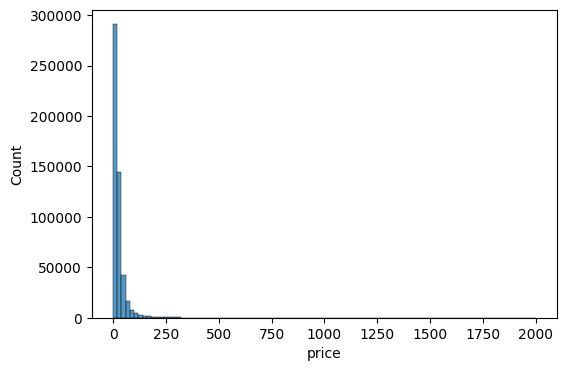

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

y_train_df = mercari_df['price']
plt.figure(figsize=(6,4))
sns.histplot(y_train_df, bins=100)
plt.show()

price 값이 비교적 적은 가격을 가진 데이터 값에 돼곡돼 분포

Price 칼럼을 로그값으로 변환한 뒤 분포도 살펴보기


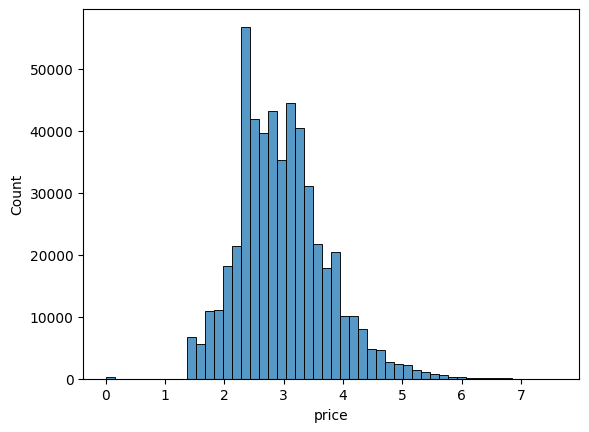

In [28]:
import numpy as np

y_train_df = np.log1p(y_train_df)
sns.histplot(y_train_df, bins=50)
plt.show()

비교적 정규 분포에 가까워짐

price 칼럼을 원래 값에서 로그로 변환된 값으로 변경

In [29]:
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

,price
0,2.397895
1,3.970292
2,2.397895


shipping, item_condition_id 유형

In [30]:
print('Shipping 값 유형:\n', mercari_df['shipping'].value_counts())
print ('item_condition_id 값 유형: \n', mercari_df ['item_condition_id' ].value_counts())

Shipping 값 유형:
 shipping
0    286089
1    230589
Name: count, dtype: int64
item_condition_id 값 유형: 
 item_condition_id
1    223027
3    150455
2    131271
4     11092
5       833
Name: count, dtype: int64


Shipping : 배송비 유무, 비교적 균일

Item_condition_id : 판매자가 제공하는 제품 상태, 1,2,3 으로 이루어짐

item_description : Null 값은 별로 없음, description에 대한 별도 설명이 없는 경우 No description yet 값으로 되어 있음 -> 확인

In [31]:
boolean_cond= mercari_df['item_description']=='No description yet'
mercari_df[boolean_cond]['item_description'].count()

28782

In [32]:
#apply lambda에서 호출되는 대, 중, 소 분할 함수 생성, 대, 중, 소 값을 리스트로 반환
def split_cat(category_name):
    try:
        return category_name.split('/')
    except:
        return ['Other_Null', '0ther_Null', 'Other_Null']
#위의 split_cat( )을 apply lambda에서 호출해 대, 중, 소 칼럼을 mercari_df에 생성.
mercari_df ['cat_dae'], mercari_df ['cat_jung'], mercari_df ['cat_so'] = \
                        zip(*mercari_df ['category_name'].apply(lambda x : split_cat(x)))

#대분류만 값의 유형과 건수를 살펴보고, 중분류, 소분류는 값의 유형이 많으므로 분류 개수만 추출
print('대분류 유형 :\n', mercari_df['cat_dae'].value_counts())
print('중분류 개수 :',mercari_df['cat_jung'].nunique())
print('소분류 개수 :', mercari_df['cat_so'].nunique())

대분류 유형 :
 cat_dae
Women                     231579
Beauty                     72585
Kids                       59566
Electronics                42734
Men                        32677
Home                       23822
Vintage & Collectibles     16263
Other                      15845
Handmade                   10683
Sports & Outdoors           8711
Other_Null                  2213
Name: count, dtype: int64
중분류 개수 : 114
소분류 개수 : 823


brand_name, category name, item_description 칼럼의 Null 값은 일괄적으로 ‘Other Null’로 동일하게 변경

In [33]:
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value='Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value='Other_Null')

#각 칼럼별로 Null 값 건수 확인. 모두 0이 나와야 합니다.
mercari_df.isnull().sum()

,0
train_id,0
name,0
item_condition_id,0
category_name,0
brand_name,0
price,0
shipping,0
item_description,0
cat_dae,0
cat_jung,0


- 피처 인코딩과 피처 벡터화

예측 모델은 Price 값 예측애햐 하므로 회귀모델 기반

선형 회귀 모델과 회귀 트리 모델 모두 적용, 원-핫 인코딩 적용, 짧은 텍스트 -> Count 기반 벡터화, 긴 텍스트 TD-IDF 기반의 벡터화

brand_name : 상품의 브랜드명

In [34]:
print('brand name 의 유형 건수 ：', mercari_df['brand_name'].nunique())
print('brand name sample 5건 : \n', mercari_df['brand_name'].value_counts()[:5])

brand name 의 유형 건수 ： 3615
brand name sample 5건 : 
 brand_name
Other_Null           220411
PINK                  18867
Nike                  18590
Victoria's Secret     16859
LuLaRoe               10735
Name: count, dtype: int64


대부분 명료한 문자열, 그냥 인코딩 변환

name : 상품명

In [35]:
print('name 의 종류 개수 ：', mercari_df['name'].nunique())
print('name sample 7건: \n', mercari_df['name'][:7])

name 의 종류 개수 ： 454614
name sample 7건: 
 0    MLB Cincinnati Reds T Shirt Size XL
1       Razer BlackWidow Chroma Keyboard
2                         AVA-VIV Blouse
3                  Leather Horse Statues
4                   24K GOLD plated rose
5       Bundled items requested for Ruie
6     Acacia pacific tides santorini top
Name: name, dtype: object


종류 매우 많음, 적은 단어 위주의 텍스트 형태 -> Count 기반으로 피처 벡터화 변환 적용

category_name 칼럼 : 각각 원-핫 인코딩

shipping : 배송비 무료 여부, 0,1 2가지 유형

item_condition_id : 상품 상태, 1,2,3,4,5 5가지 유형

-> 둘다 원-핫 인코딩

item_description : 상품에 대한 간단 설명, 가장 긴 텍스트

평균 문자열 크기와 2개 정도의 텍스트 추출 -> 145로 매우 크므로 TF-IDF로 변환

In [36]:
pd.set_option('max_colwidth', 200)

# item_description의 평균 문자열 크기
print('item_description 평균 문자열 크기:', mercari_df['item_description'].str.len().mean())

mercari_df['item_description'][:2]

item_description 평균 문자열 크기: 145.6005906967202


,item_description
0,No description yet
1,This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.


주요 칼럼 인코딩 및 피처 벡터화 변환

In [37]:
#name 속성에 대한 피처 벡터화 변환
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(mercari_df.name)

#item_description에 대한 피처 벡터화 변환
tfidf_descp = TfidfVectorizer(max_features = 50000, ngram_range= (1, 3), stop_words='english')
X_descp = tfidf_descp.fit_transform(mercari_df['item_description'])

In [38]:
print('name vectorization shape：', X_name.shape)
print('item_description vectorization shape：', X_descp.shape)

name vectorization shape： (516678, 59509)
item_description vectorization shape： (516678, 50000)


CountVectorizer, TfidfVectorizer가 fit_transform()을 통해 반환하는 데이터 -> 희소 행렬 형태

희소 행렬 객체 변수 X_name과 X_desp를 새로 결합해 새로운 데이터 세트로 구성

앞으로 인코딩될 피처들도 모두 결합돼 ML 모델을 실행하는 기반 데이터 세트로 재구성

-> 인코딩 대상 칼럼도 밀집이 아닌 희소 행렬 형태로 인코딩 적용한 뒤 함께 결합

사이킷런의 원-핫 인코딩 클래스: OneHotEncoder, LabelBinarizer

LabelBinarizer: 희소 행렬 형태의 원-핫 인코딩 변환을 지원, sparse_out=True 설정

모든 인코딩 대상 칼럼은 LabelBinarizer를 이용해 희소 행렬 형태의 원-핫 인코딩으로 변환

sparse 모듈의 hstack() 함수를 이용해 결합

개별 칼럼으로 만들어진 희소 행렬이 칼럼 레벨로 결합할 수 있게 함

인코딩 대상 칼럼을 LabelBinarizer를 이용해 원-핫 인코딩으로 변환

In [39]:
from sklearn.preprocessing import LabelBinarizer

# brand-name, item_condition_id, shipping 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_brand_name= LabelBinarizer(sparse_output=True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])
lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])
lb_shipping= LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

# cat_dae, cat Jung, cat_so 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output=True)
X_cat_dae= lb_cat_dae.fit_transform(mercari_df['cat_dae'])
lb_cat_jung = LabelBinarizer(sparse_output=True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df ['cat_jung'])
lb_cat_so = LabelBinarizer(sparse_output=True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])

제대로 변환됐는지 생성된 인코딩 데이터 세트의 타이봐 shape 살펴보기

In [40]:
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print('X_brand shape：{0}, X_item_cond_id shape：{1}'.format(X_brand.shape, X_item_cond_id.shape))
print('X_shipping shape：{0}, X_cat_dae shape：{1}'.format(X_shipping.shape, X_cat_dae.shape))
print('X_cat_jung shape:{0}, X_cat_so shape：{1}'.format(X_cat_jung.shape, X_cat_so.shape))

<class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'>
X_brand shape：(516678, 3615), X_item_cond_id shape：(516678, 5)
X_shipping shape：(516678, 1), X_cat_dae shape：(516678, 11)
X_cat_jung shape:(516678, 114), X_cat_so shape：(516678, 823)


피처 벡터화 변환한 데이터 세트와 희소 인코딩 변환된 데이터 세트를 hstack()을 이용하여 모두 결합

만들어진 결합 데이터가 비교적 많은 메모리를 잡아먹기 때문에 del '객체 변수명'과 gc.collect()로 결합 데이터를 메모리에서 삭제

In [41]:
from scipy.sparse import hstack
import gc

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

#hstack 함수를 이용해 인코딩과 벡터화를 수행한 데이터 세트를 모두 결합.
X_features_sparse= hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

#데이터 세트가 메모리를 많이 차지하므로 사용 목적이 끝났으면 바로 메모리에서 삭제.
del X_features_sparse
gc.collect()

<class 'scipy.sparse._csr.csr_matrix'> (516678, 114078)


0

- 릿지 회귀 모델 구축 및 평가

평가 로직 함수화 : RMSLE 평가 지표 적용(오류 값에 로그를 취해 RMSE를 구하는 방식)


In [42]:
def rmsle(y, y_pred):
    #underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle 계산
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

def evaluate_org_price(y_test, preds):
    #원본 데이터는 loglp로 변환되었으므로 exmpml로 원복 필요.
    preds_exmpm = np.expm1(preds)
    y_test_exmpm = np.expm1(y_test)

    #rmsle로 RMSLE 값 추출
    rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
    return rmsle_result

학습용 데이터 생성, 모델 학습/예측하는 로직을 별도의 함수로 생성

In [43]:
import gc
from scipy.sparse import hstack

def model_train_predict(model, matrix_list):
    #scipy.sparse 모듈의 hstack을 이용해 희소 행렬 결합
    X= hstack(matrix_list).tocsr()
    X_train, X_test, y_train, y_test=train_test_split(X, mercari_df['price'], test_size=0.2, random_state=156)

    #모델 학습 및 예측
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    del X, X_train, X_test, y_train
    gc.collect()

    return preds, y_test

Ridge를 이용해 Mercari Price의 회귀 예측 수행

Item_description 속성의 피처 벡터화 데이터가 포함/포함x 예측 성능 비교 -> 영향력 확인



In [44]:
linear_model = Ridge(solver = "lsqr", fit_intercept=False)

sparse_matrix_list = (X_name, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test = model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)
print('Item Description을 제외했을 때 rmsle 값:', evaluate_org_price(y_test, linear_preds))

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test = model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)
print('Item Description을 포함한 rmsle 값:', evaluate_org_price(y_test, linear_preds))

Item Description을 제외했을 때 rmsle 값: 0.5077159979521805
Item Description을 포함한 rmsle 값: 0.4823345764329522


- LightGBM 회귀 모델 구축과 앙상블을 이용한 최종 예측 평가

LightGBM을 이용해 회귀 수행, 릿지 모델 예측값과 LightGBM 모델 예측값을 간단한 앙상블 방식으로 섞어서 최종 회귀 예측값 평가

In [45]:
from lightgbm import LGBMRegressor

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
lgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.5, num_leaves=125, random_state=156)
lgbm_preds, y_test = model_train_predict(model = lgbm_model, matrix_list=sparse_matrix_list)
print('LightGBM rmsle 값:', evaluate_org_price(y_test, lgbm_preds))

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 380.256406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1053411
[LightGBM] [Info] Number of data points in the train set: 413342, number of used features: 57501
[LightGBM] [Info] Start training from score 2.978703
LightGBM rmsle 값: 0.48182378741319326


In [46]:
preds = lgbm_preds * 0.45 + linear_preds * 0.55
print('LightGBM과 Ridge를 ensemble한 최종 rmsle 값:', evaluate_org_price(y_test, preds))

LightGBM과 Ridge를 ensemble한 최종 rmsle 값: 0.4626358062719858


# 11 정리

- 머신러닝 기반의 텍스트 분석 프로세스

텍스트 사전 정제 작업 등의 텍스트 정규화 작업을 수행 -> 이들 단어들을 피처 벡터화로 변환 -> 이렇게 생성된 피처 벡터 데이터 세트에 머신러닝 모델을 학습하고 예측 및 평가

- 텍스트 정규화 작업 : 텍스트 클렌징 및 대소문자 변경, 단어 토큰화, 의미 없는 단어 필터링, 어근 추출 등 피처 벡터화를 진행하기 이전에 수행하는 다양한 사전 작업

- 피처 벡터화 : BOW 의 대표 방식인 Count 기반과 TF-IDF 기반 피처 벡터화

문서의 문장이 긴 경우: TF-IDF 기반의 피처 벡터가 더 정확한 결과를 도출하는 데 더 효과적

- 텍스트 분류 : 문서들을 피처 벡터화한 후 로지스틱 회귀를 적용해 문서를 지도학습 방식으로 예측 및 분류

- 감성 분석 : 지도학습 기반으로 긍정/부정 이진 분류를 적용한 방식, SentiWordNet, VADER와 같은 감성 사전 Lexicon을 이용한 방식

- 토픽 모델링 : LDA(Latent Dirichlet Allocation)를 이용

- 텍스트 군집화 : K-평균 군집화 기법을 이용해 비슷한 문서들끼리 군집화

- 텍스트 유사도 측정 : 코사인 유사도 이용